In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import subprocess
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py

tqdm.pandas()


## Dataset relative path and raw data interface.

In [3]:
BP4D_PATH = os.path.join('..', 'resources', 'BP4D')
FEATURE_PATH = os.path.join(BP4D_PATH, 'raw', '2DFeatures')
SEQUENCE_PATH = os.path.join(BP4D_PATH, 'raw', 'sequences')
offset = 0.15 * np.concatenate([np.zeros((49, 1)), np.ones((49, 1))], axis=-1)

RAW_IMAGE_TEMPLATE = os.path.join(BP4D_PATH, 'raw', 'sequences', '{}{:03d}', 'T{}', 'frame{:04d}.jpg')
RAW_LANDMARK_TEMPLATE = os.path.join(BP4D_PATH, 'raw', '2DFeatures', '{}{:03d}_T{}.mat')
FEATURE_3D_TEMPLATE = os.path.join(BP4D_PATH, 'raw', '3DFeatures', '{}{:03d}', 'T{}', '{:04d}.tbnd')
RAW_AU_OCC = os.path.join(BP4D_PATH, 'raw', 'AUCoding', 'AU_OCC', '{}{:03d}_T{}.csv')
FOLD_PATH_GEN = os.path.join(BP4D_PATH, 'preprocessed', 'folds', 'fold{}.csv')
FOLD_PATH = os.path.join(BP4D_PATH, 'preprocessed', 'folds', 'BP4D_part{}_path.txt')


PREPROCESSED_IMAGE_TEMPLATE = os.path.join(BP4D_PATH, 'preprocessed', 'sequences', '{}{:03d}', 'T{}', 'frame{:04d}.jpg')
PREPROCESSED_LANDMARK_TEMPLATE = os.path.join(BP4D_PATH, 'preprocessed', '2DFeatures', '{}{:03d}_T{}', 'frame{:04d}.npz')
PREPROCESSED_DF = os.path.join(BP4D_PATH, 'preprocessed', 'full_info.csv')


def get_raw_landmark(sex, subject, task):
    return RAW_LANDMARK_TEMPLATE.format(sex, subject, task)

def get_preprocessed_landmark(sex, subject, task, frame):
    return PREPROCESSED_LANDMARK_TEMPLATE.format(sex, subject, task, frame)

def get_sex_subject_task(path):
    basename = os.path.basename(path)
    sex = basename[0]
    subject = int(basename[1:4])
    task = int(os.path.splitext(basename)[0][-1])
    return sex, subject, task

def get_dest_path(x):
    sex, subject, task, frame = x['sex'], x['id'], x['task'], x['frame']
    return PREPROCESSED_IMAGE_TEMPLATE.format(sex, subject, task, frame)

def split_sex_id_task_frame(x):
    split_list = x.split('/')
    frame_str = split_list[-1].split('.')[0]
    task_str = split_list[-2]
    identifier_str = split_list[-3]
    frame = int(frame_str[-4:])
    task = int(task_str[-1])
    sex = identifier_str[0]
    identifier = int(identifier_str[1:])
    return identifier_str, task, frame

def get_tuple(i):
    def fun(x):
        return x[i]
    return fun

def map_dictionary(dictionary):
    def fun(x):
        return dictionary[x]
    return fun

## Landmark expansion from .mat to list of frames.

In [56]:
sex, subject, task = 'M', 1, 1
test_path = get_raw_landmark(sex, subject, task)


def parse_landmark_file(sex, subject, task):
    path = get_raw_landmark(sex, subject, task)
    with h5py.File(path, 'r') as f:
        # Get the data
        refs_landmarks = f['fit']['pred'][:, 0]
        refs_rot = f['fit']['pose'][:, 0]
        # print(rotation_angle)
    
        landmarks_frames = []
        rotation_matrix_frames = []
        rotation_angle_frames = []
        for i in range(len(refs_landmarks)):
            dict_to_save = dict()
            landmarks = np.array(f[refs_landmarks[i]])
            
            if landmarks.shape == (2, 49):
                dict_to_save['landmarks'] = landmarks
                
            
            f_rot = f[refs_rot[i]]
            if hasattr(f_rot, 'keys'):
                rotation_matrix = np.reshape(np.array(f[refs_rot[i]]['rot']), (3, 3))
                dict_to_save['rotation_matrix'] = rotation_matrix
        
                rotation_angle = np.reshape(np.array(f[refs_rot[i]]['angle']), (3,))
                dict_to_save['rotation_angle'] = rotation_angle
        
        #rotation_matrices = np.concatenate(rotation_matrix_frames, axis=0)
        #rotation_angles = np.concatenate(rotation_angle_frames, axis=0)
        
            save_path = get_preprocessed_landmark(sex, subject, task, frame=i)
            dir_path = os.path.dirname(save_path)
            if not(os.path.exists(dir_path)):
                os.makedirs(dir_path)
            np.savez(save_path, **dict_to_save)

def tbnd_to_numpy(tbnb_file):
    return pd.read_csv(tbnb_file, sep='', header=None, names=['pitch', 'row', 'roll'])

def get_preprocessed_landmarks_apply(x):
    sex, subject, task, frame = x['sex'], x['id'], x['task'], x['frame']
    return get_preprocessed_landmark(sex, subject, task, frame)

from tqdm import tqdm

feature_list = os.listdir(FEATURE_PATH)



In [4]:
for video in tqdm(feature_list):
    full_path = os.path.join(FEATURE_PATH, video)
    sex, subject, task = get_sex_subject_task(full_path)
    parse_landmark_file(sex, subject, task)
    
    
experiment_list = os.listdir(SEQUENCE_PATH)
frames = []
for experiment in experiment_list:
    print(experiment)
    experiment_path = os.path.join(SEQUENCE_PATH, experiment)
    if os.path.isdir(experiment_path):
        task_list = os.listdir(experiment_path)
        for task in task_list:
            print(task)
            frame_list = os.listdir(os.path.join(experiment_path, task))
            frame_list = [os.path.join(experiment_path, task, frame) for frame in frame_list]
            frames += frame_list

  0%|          | 1/328 [00:03<16:53,  3.10s/it]


KeyboardInterrupt: 

In [84]:
experiment_df['dest_path'] = experiment_df.apply(get_dest_path, axis=1)
experiment_df['2D_features'] = experiment_df.apply(get_preprocessed_landmarks_apply, axis=1)

In [439]:
from tqdm import tqdm
import cv2
tqdm.pandas()

def read_align_save(src_path, dest_path, landmarks):
    image = cv2.imread(src_path)
    faceAligned = align_faces(image, landmarks, desired_left_eye=(0.35, 0.35), desired_size=160)
    return cv2.imwrite(dest_path, faceAligned)
    
def read_align_save_apply(x):
    src_path = x['src_path']
    dest_path = x['dest_path']
    features_2D = np.load(x['2D_features'])
    if os.path.exists(dest_path):
        return True
    if 'landmarks' in features_2D:
        
        landmarks = features_2D['landmarks']
        return read_align_save(src_path, dest_path, landmarks)
    else:
        print('no landmark in {}'.format(src_path))
        return False
    
def get_landmarks(x):
    features_2D = np.load(x['2D_features'])
    has_landmarks = ('landmarks' in features_2D)
    if 'landmarks' in features_2D:
        landmarks = features_2D['landmarks']
    else:
        landmarks = None
    return 
    
    
def align_crop_opencv(img,
                      src_landmarks,
                      standard_landmarks,
                      crop_size=512,
                      face_factor=0.7,
                      align_type='similarity',
                      order=3,
                      mode='edge'):
    """Align and crop a face image by landmarks.
    Arguments:
        img                : Face image to be aligned and cropped.
        src_landmarks      : [[x_1, y_1], ..., [x_n, y_n]].
        standard_landmarks : Standard shape, should be normalized.
        crop_size          : Output image size, should be 1. int for (crop_size, crop_size)
                             or 2. (int, int) for (crop_size_h, crop_size_w).
        face_factor        : The factor of face area relative to the output image.
        align_type         : 'similarity' or 'affine'.
        order              : The order of interpolation. The order has to be in the range 0-5:
                                 - 0: INTER_NEAREST
                                 - 1: INTER_LINEAR
                                 - 2: INTER_AREA
                                 - 3: INTER_CUBIC
                                 - 4: INTER_LANCZOS4
                                 - 5: INTER_LANCZOS4
        mode               : One of ['constant', 'edge', 'symmetric', 'reflect', 'wrap'].
                             Points outside the boundaries of the input are filled according
                             to the given mode.
    """
    # set OpenCV
    import cv2
    inter = {0: cv2.INTER_NEAREST, 1: cv2.INTER_LINEAR, 2: cv2.INTER_AREA,
             3: cv2.INTER_CUBIC, 4: cv2.INTER_LANCZOS4, 5: cv2.INTER_LANCZOS4}
    border = {'constant': cv2.BORDER_CONSTANT, 'edge': cv2.BORDER_REPLICATE,
              'symmetric': cv2.BORDER_REFLECT, 'reflect': cv2.BORDER_REFLECT101,
              'wrap': cv2.BORDER_WRAP}

    # check
    assert align_type in ['affine', 'similarity'], 'Invalid `align_type`! Allowed: %s!' % ['affine', 'similarity']
    assert order in [0, 1, 2, 3, 4, 5], 'Invalid `order`! Allowed: %s!' % [0, 1, 2, 3, 4, 5]
    assert mode in ['constant', 'edge', 'symmetric', 'reflect', 'wrap'], 'Invalid `mode`! Allowed: %s!' % ['constant', 'edge', 'symmetric', 'reflect', 'wrap']

    # crop size
    if isinstance(crop_size, (list, tuple)) and len(crop_size) == 2:
        crop_size_h = crop_size[0]
        crop_size_w = crop_size[1]
    elif isinstance(crop_size, int):
        crop_size_h = crop_size_w = crop_size
    else:
        raise Exception('Invalid `crop_size`! `crop_size` should be 1. int for (crop_size, crop_size) or 2. (int, int) for (crop_size_h, crop_size_w)!')

    # estimate transform matrix
    trg_landmarks = standard_landmarks * max(crop_size_h, crop_size_w) * face_factor + np.array([crop_size_w // 2, crop_size_h // 2])
    if align_type == 'affine':
        tform = cv2.estimateAffine2D(trg_landmarks, src_landmarks, ransacReprojThreshold=np.Inf)[0]
    else:
        tform = cv2.estimateAffinePartial2D(trg_landmarks, src_landmarks, ransacReprojThreshold=np.Inf)[0]

    # warp image by given transform
    output_shape = (crop_size_h, crop_size_w)
    img_crop = cv2.warpAffine(img, tform, output_shape[::-1], flags=cv2.WARP_INVERSE_MAP + inter[order], borderMode=border[mode])

    # get transformed landmarks
    tformed_landmarks = cv2.transform(np.expand_dims(src_landmarks, axis=0), cv2.invertAffineTransform(tform))[0]

    return img_crop, tformed_landmarks

standard_landmarks = np.load(os.path.join('..', 'resources', 'Face_aligner', 'standard_landmark_49pts.npy'))
offset = 0.15 * np.concatenate([np.zeros((49, 1)), np.ones((49, 1))], axis=-1)
labeled_dfs_tot = pd.read_csv(PREPROCESSED_DF)

def load_align_and_save(x):
    src_path = x['src_path']
    dest_path = x['dest_path']
    features_2D = np.load(x['2D_features'])
    if 'landmarks' in features_2D:
        landmarks = features_2D['landmarks'].T
        src_image = cv2.imread(src_path)
        dest_image, tformed_landmarks = align_crop_opencv(src_image,
                                                          src_landmarks=landmarks,
                                                          standard_landmarks=standard_landmarks,
                                                          face_factor=0.9,
                                                          crop_size=299)
        cv2.imwrite(dest_path, dest_image)
        return True
    else:
        return False
    
    
labeled_dfs_tot['has_landmarks'] = labeled_dfs_tot.progress_apply(load_align_and_save, axis=1)



100%|█| 146847/146847 [2:59:59<00:00, 13


In [509]:
labeled_dfs_tot = pd.read_csv(PREPROCESSED_DF)

def has_correct_shape(path):
    a = cv2.imread(path)
    return np.array(a).shape == (299, 299, 3)

def shape(path):
    a = cv2.imread(path)
    return np.array(a).shape

# labeled_dfs_tot['has_been_processed'] = labeled_dfs_tot['dest_path'].map(has_correct_shape)


In [511]:
labeled_dfs_tot.loc[labeled_dfs_tot['identification'] == 'F004'].progress_apply(load_align_and_save, axis=1)

  0%|          | 0/3737 [00:00<?, ?it/s]

81880    True
81881    True
81882    True
81883    True
81884    True
         ... 
85612    True
85613    True
85614    True
85615    True
85616    True
Length: 3737, dtype: bool

In [179]:
a = pd.read_csv(RAW_AU_OCC.format('M', 1, 1))


mapper = dict({"0": "frame"})
for i in range(1, 100):
    mapper[str(i)] = 'AU{}'.format(str(i))
    
tracked_au = ["1", "2", "4", "6", "7", "10", "12", "14", "15", "17", "23", "24"]


def preprocessed_labels(sex, subject, task):
    labels = pd.read_csv(RAW_AU_OCC.format(sex, subject, task))
    return labels[["0"] + tracked_au].rename(columns=mapper)
    
preprocessed_labels('M', 1, 4)
    df1.merge(df2, left_on='lkey', right_on='rkey')

frame  AU1  AU2  AU4  AU6  AU7  AU10  AU12  AU14  AU15  AU17  AU23  AU24
0      564    0    0    0    0    1     0     1     0     0     0     0     0
1      565    0    0    0    0    1     0     1     0     0     0     0     0
2      566    0    0    0    0    1     0     1     0     0     0     0     0
3      567    0    0    0    0    1     0     1     0     0     0     0     0
4      568    0    0    0    0    1     0     1     0     0     0     0     0
..     ...  ...  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...   ...
585   1149    0    0    0    0    1     1     1     0     0     0     0     0
586   1150    0    0    0    0    1     1     1     0     0     0     0     0
587   1151    0    0    0    0    1     1     1     0     0     0     0     0
588   1152    0    0    0    0    1     1     1     0     0     0     0     0
589   1153    0    0    0    0    1     1     1     0     0     0     0     0

[590 rows x 13 columns]

In [183]:
from tqdm.notebook import tqdm

labeled_dfs = []
sexes = ['M', 'F']

for sex in tqdm(sexes):
    sex_df = experiment_df.loc[experiment_df['sex'] == sex]
    identifiers = sex_df['id'].unique()
    for identifier in tqdm(identifiers):
        sex_identifier_df = sex_df.loc[sex_df['id'] == identifier]
        tasks = sex_identifier_df['task'].unique()
        for task in tqdm(tasks):
            sex_identifier_task_df = sex_identifier_df.loc[sex_df['task'] == task]
            
            preprocessed_labels_sit = preprocessed_labels(sex, identifier, task)
            labeled_dfs.append(sex_identifier_task_df.merge(preprocessed_labels_sit, on='frame'))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
from collections import Counter
import numpy as np




labeled_dfs_tot = pd.read_csv(PREPROCESSED_DF)
#labeled_dfs_tot['identification'] = labeled_dfs_tot.apply(subject_identifier, axis=1)
#labeled_dfs_tot = labeled_dfs_tot.drop(columns=['sex', 'id'])
# labeled_dfs_tot.to_csv(PREPROCESSED_DF, index=False)

print(labeled_dfs_tot.head(10))



ethnicity_dict = {'F001': 'AA',
                  'F002': 'A',
                  'F003': 'A',
                  'F004': 'EA',
                  'F005': 'A',
                  'F006': 'EA',
                  'F007': 'A',
                  'F008': 'EA',
                  'F009': 'A',
                  'F010': 'EA',
                  'F011': 'AA',
                  'F012': 'AA',
                  'F013': 'EA',
                  'F014': 'A',
                  'F015': 'A',
                  'F016': 'EA',
                  'F017': 'EA',
                  'F018': 'H',
                  'F019': 'EA',
                  'F020': 'EA',
                  'F021': 'A',
                  'F022': 'AA',
                  'F023': 'AA',
                  'M001': 'EA',
                  'M002': 'EA',
                  'M003': 'AA',
                  'M004': 'EA',
                  'M005': 'A',
                  'M006': 'EA',
                  'M007': 'EA',
                  'M008': 'A',
                  'M009': 'EA',
                  'M010': 'EA',
                  'M011': 'H',
                  'M012': 'H',
                  'M013': 'EA',
                  'M014': 'EA',
                  'M015': 'H',
                  'M016': 'EA',
                  'M017': 'A',
                  'M018': 'EA'}

ethnicity_category = dict({'EA': [1, 0, 0, 0],
                           'A': [0, 1, 0, 0],
                           'H': [0, 0, 1, 0],
                           'AA': [0, 0, 0, 1]})
sex_category = dict({'M': [1, 0],
                     'F': [0, 1]})


def get_ethnicity(identification):
    return ethnicity_category[ethnicity_dict[identification]]

def get_sex(identification):
    return sex_category[identification[0]]

def get_element(i):
    def fun(L):
        return L[i]
    return fun

def get_onehot(el):
    return list(np.identity(8)[el - 1, :])


label_list = []
tracked_aus = ["1", "2", "4", "6", "7", "10", "12", "14", "15", "17", "23", "24"]
for tracked_au in tracked_aus:
    labeled_dfs_tot['no_AU{}'.format(tracked_au)] = 1 - labeled_dfs_tot['AU{}'.format(tracked_au)]
    label_list += ['AU{}'.format(tracked_au), 'no_AU{}'.format(tracked_au)]
    
labeled_dfs_tot['sex'] = labeled_dfs_tot['identification'].map(get_sex)
labeled_dfs_tot['M'] = labeled_dfs_tot['sex'].map(get_element(0))
labeled_dfs_tot['F'] = labeled_dfs_tot['sex'].map(get_element(1))
label_list += ['M', 'F']

labeled_dfs_tot['ethnicity'] = labeled_dfs_tot['identification'].map(get_ethnicity)
labeled_dfs_tot['EA'] = labeled_dfs_tot['ethnicity'].map(get_element(0))
labeled_dfs_tot['A'] = labeled_dfs_tot['ethnicity'].map(get_element(1))
labeled_dfs_tot['H'] = labeled_dfs_tot['ethnicity'].map(get_element(2))
labeled_dfs_tot['AA'] = labeled_dfs_tot['ethnicity'].map(get_element(3))
label_list += ['EA', 'A', 'H', 'AA']

labeled_dfs_tot['task_onehot'] = labeled_dfs_tot['task'].map(get_onehot)
for i in range(1, 9):
    labeled_dfs_tot['task{}'.format(i)] = labeled_dfs_tot['task_onehot'].map(get_element(i - 1))
label_list += ['task{}'.format(i) for i in range(1, 9)]


                                           src_path  task  frame  \
0  ../resources/BP4D/raw/sequences/M003/T7/1793.jpg     7   1793   
1  ../resources/BP4D/raw/sequences/M003/T7/1397.jpg     7   1397   
2  ../resources/BP4D/raw/sequences/M003/T7/1524.jpg     7   1524   
3  ../resources/BP4D/raw/sequences/M003/T7/1700.jpg     7   1700   
4  ../resources/BP4D/raw/sequences/M003/T7/1877.jpg     7   1877   
5  ../resources/BP4D/raw/sequences/M003/T7/1635.jpg     7   1635   
6  ../resources/BP4D/raw/sequences/M003/T7/1854.jpg     7   1854   
7  ../resources/BP4D/raw/sequences/M003/T7/1819.jpg     7   1819   
8  ../resources/BP4D/raw/sequences/M003/T7/1461.jpg     7   1461   
9  ../resources/BP4D/raw/sequences/M003/T7/1831.jpg     7   1831   

                                           dest_path  \
0  ../resources/BP4D/preprocessed/sequences/M003/...   
1  ../resources/BP4D/preprocessed/sequences/M003/...   
2  ../resources/BP4D/preprocessed/sequences/M003/...   
3  ../resources/BP4D/prepro

In [128]:
single_identifiers = ["0", "1", "2"]
duet_identifiers = ["01", "02", "12"]


def check_exist(dest_path):
    return os.path.exists(dest_path)

def sub_identifier(x):
    return '{}{:03d}'.format(x['sex'], int(x['id']))

def preprocessed_fold_df(part):
    part_df = pd.read_csv(FOLD_PATH.format(part), header=None, names=['path'])
    part_df['mixted'] = part_df['path'].map(split_sex_id_task_frame)
    part_df['sex'] = part_df['mixted'].map(get_tuple(0))
    part_df['id'] = part_df['mixted'].map(get_tuple(1))
    part_df['identification'] = part_df.apply(sub_identifier, axis=1)
    part_df.drop(columns=['sex', 'id'])
    part_df['task'] = part_df['mixted'].map(get_tuple(2))
    part_df['frame'] = part_df['mixted'].map(get_tuple(3))
    part_df = part_df.drop(columns=['path', 'mixted'])
    part_labeled_df = labeled_dfs_tot.merge(part_df, on=['identification', 'task', 'frame'])
    return part_labeled_df

def format_labeled_df(df):
    df['exist'] = df['dest_path'].map(check_exist)
    df = df.loc[df['exist']]
    return (df[label_list + ['dest_path']]
            .rename(columns={'dest_path': 'path'}))

def subject_identifier(x):
    return '{}{:3d}'.format(x['sex'], x['id'])

def split_on_identification(fold_df):
    unique_identifiers = fold_df['identification'].unique()
    fold0_identifiers = unique_identifiers[:9]
    fold1_identifiers = unique_identifiers[9:18]
    fold2_identifiers = unique_identifiers[18:]
    
    fold0_df = fold_df.loc[fold_df['identification'].isin(fold0_identifiers)]
    fold1_df = fold_df.loc[fold_df['identification'].isin(fold1_identifiers)]
    fold2_df = fold_df.loc[fold_df['identification'].isin(fold2_identifiers)]
    
    return [fold0_df, fold1_df, fold2_df]
    

# Single fold combinations
fold_dfs = []
for i in range(len(single_identifiers)):
    fold_df = preprocessed_fold_df(i + 1)
    format_labeled_df(fold_df).to_csv(FOLD_PATH_GEN.format(single_identifiers[i]), index=False)
    fold_dfs.append(fold_df)
    
# Duet fold combinations
duet_fold_dfs = []
for duet_identifier in duet_identifiers:
    duet_fold_df = pd.concat([fold_dfs[int(i)] for i in duet_identifier])
    format_labeled_df(duet_fold_df).to_csv(FOLD_PATH_GEN.format(duet_identifier), index=False)
    # Single fold combination from duet fold
    single_duet_fold_dfs = split_on_identification(duet_fold_df)
    for i in range(len(single_duet_fold_dfs)):
        format_labeled_df(single_duet_fold_dfs[i]).to_csv(FOLD_PATH_GEN.format(duet_identifier +
                                                                           '-' +
                                                                           single_identifiers[i]),
                                                         index=False)
    for double_duet_identifier in duet_identifiers:
        double_duet_fold_df = pd.concat([single_duet_fold_dfs[int(i)] for i in double_duet_identifier])
        format_labeled_df(double_duet_fold_df).to_csv(FOLD_PATH_GEN.format(duet_identifier + 
                                                                           '-' +
                                                                           double_duet_identifier),
                                                     index=False)

<ipython-input-128-7e8048c1e378>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exist'] = df['dest_path'].map(check_exist)


In [6]:
AU_numbers = [1, 2, 4, 6, 7, 10, 12, 14, 15, 17, 23, 24]
AU_names = ["AU{}".format(au) for au in AU_numbers]

In [17]:
# Test 
fold0 = pd.read_csv(FOLD_PATH_GEN.format("0"))
fold1 = pd.read_csv(FOLD_PATH_GEN.format("1"))
fold2 = pd.read_csv(FOLD_PATH_GEN.format("2"))
# print("2 : ", fold2['identification'].unique())

fold01 = pd.read_csv(FOLD_PATH_GEN.format("01"))
# print("01 : ", fold01['identification'].unique())
AU_occ01 = fold01[AU_names].sum(axis=0)
AU_r01 = 1 / fold01[AU_names].sum(axis=0)
AU_w01 = AU_r01/AU_r01.sum()

print('01 : ', AU_w01)


fold02 = pd.read_csv(FOLD_PATH_GEN.format("02"))

AU_occ02 = fold02[AU_names].sum(axis=0)
AU_r02 = 1 / fold02[AU_names].sum(axis=0)
AU_w02 = AU_r02/AU_r02.sum()
print('02 : ', AU_w02)
# print("02 : ", fold02['identification'].unique())

fold12 = pd.read_csv(FOLD_PATH_GEN.format("12"))

AU_occ12 = fold12[AU_names].sum(axis=0)
AU_r12 = 1 / fold12[AU_names].sum(axis=0)
AU_w12 = AU_r12/AU_r12.sum()
print('12 : ', AU_w12)

# print("12 : ", fold12['identification'].unique())

fold01_0 = pd.read_csv(FOLD_PATH_GEN.format("01-0"))
# print("01-0: ", fold01_0['identification'].unique())

fold01_0 = pd.read_csv(FOLD_PATH_GEN.format("01-0"))
# print("01-0: ", fold01_0['identification'].unique())

fold01_1 = pd.read_csv(FOLD_PATH_GEN.format("01-1"))
# print("01-1: ", fold01_1['identification'].unique())

fold01_2 = pd.read_csv(FOLD_PATH_GEN.format("01-2"))
# print("01-2: ", fold01_2['identification'].unique())

fold01_01 = pd.read_csv(FOLD_PATH_GEN.format("01-01"))
# print("01-01: ", fold01_01['identification'].unique())

fold01_02 = pd.read_csv(FOLD_PATH_GEN.format("01-02"))
# print("01-01: ", fold01_01['identification'].unique())

fold01_12 = pd.read_csv(FOLD_PATH_GEN.format("01-12"))
# print("01-12: ", fold01_12['identification'].unique())

01 :  AU1     0.112091
AU2     0.140963
AU4     0.103996
AU6     0.046775
AU7     0.036076
AU10    0.036301
AU12    0.038083
AU14    0.045081
AU15    0.117230
AU17    0.060175
AU23    0.124315
AU24    0.138914
dtype: float64
02 :  AU1     0.099637
AU2     0.112011
AU4     0.103885
AU6     0.046495
AU7     0.038950
AU10    0.034841
AU12    0.036673
AU14    0.048359
AU15    0.138905
AU17    0.064352
AU23    0.132369
AU24    0.143524
dtype: float64
12 :  AU1     0.094677
AU2     0.127190
AU4     0.109133
AU6     0.045930
AU7     0.042202
AU10    0.036953
AU12    0.039560
AU14    0.044470
AU15    0.124414
AU17    0.062336
AU23    0.132053
AU24    0.141081
dtype: float64


In [9]:
from datasets.bp4d.generation import gen_bp4d

gen_bp4d()

Index(['AU1', 'no_AU1', 'AU2', 'no_AU2', 'AU4', 'no_AU4', 'AU6', 'no_AU6',
       'AU7', 'no_AU7', 'AU10', 'no_AU10', 'AU12', 'no_AU12', 'AU14',
       'no_AU14', 'AU15', 'no_AU15', 'AU17', 'no_AU17', 'AU23', 'no_AU23',
       'AU24', 'no_AU24', 'M', 'F', 'EA', 'A', 'H', 'AA', 'task1', 'task2',
       'task3', 'task4', 'task5', 'task6', 'task7', 'task8', 'path'],
      dtype='object')


# Results

['AU1', 'AU2', 'AU4', 'AU6', 'AU7', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU23', 'AU24']


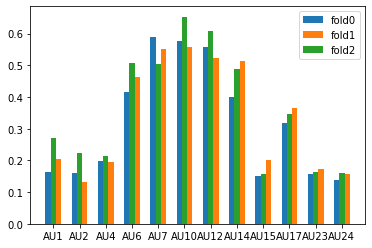

In [3]:
from datasets.bp4d.config import AU_ORDER
fold_df_au_ps = []
print(AU_ORDER)
fold_dfs = [pd.read_csv(FOLD_PATH_GEN.format(i)) for i in [0, 1, 2]]
for fold_df in fold_dfs:
    fold_df_au = fold_df[AU_ORDER]
    fold_df_au_p = fold_df_au.sum(axis=0) / fold_df_au.shape[0]
    fold_df_au_ps.append(fold_df_au_p)
    
plt.bar(np.arange(12) - 0.2,
        fold_df_au_ps[0],
        width=0.2,
        label='fold0',
        tick_label=12 * [''])

plt.bar(np.arange(12) + 0.2,
        fold_df_au_ps[1],
        width=0.2,
        label='fold1',
        tick_label=12 * [''])

plt.bar(np.arange(12),
        fold_df_au_ps[2],
        width=0.2,
        label='fold2',
        tick_label=AU_ORDER)
plt.legend()

plt.show()

In [4]:
fold_df_vec = np.stack([fold_df_au_ps[i].to_numpy() for i in range(len(fold_df_au_ps)) ])
fold_df_vec.shape
variance = np.mean(np.sum(np.power(fold_df_vec - np.mean(fold_df_vec, axis=0)[np.newaxis, :], 2), axis=1))
print(variance)

0.012483197880415728


In [5]:
bp4d_df = pd.concat(fold_dfs, axis=0)
print(bp4d_df.columns)
bp4d_df['sex_id_task_frame'] = bp4d_df['path'].map(split_sex_id_task_frame)
bp4d_df['identification'] = bp4d_df['sex_id_task_frame'].map(get_tuple(0))
bp4d_df['identification']

Index(['AU1', 'no_AU1', 'AU2', 'no_AU2', 'AU4', 'no_AU4', 'AU6', 'no_AU6',
       'AU7', 'no_AU7', 'AU10', 'no_AU10', 'AU12', 'no_AU12', 'AU14',
       'no_AU14', 'AU15', 'no_AU15', 'AU17', 'no_AU17', 'AU23', 'no_AU23',
       'AU24', 'no_AU24', 'M', 'F', 'EA', 'A', 'H', 'AA', 'task1', 'task2',
       'task3', 'task4', 'task5', 'task6', 'task7', 'task8', 'path'],
      dtype='object')


0        M008
1        M008
2        M008
3        M008
4        M008
         ... 
45773    F021
45774    F021
45775    F021
45776    F021
45777    F021
Name: identification, Length: 146545, dtype: object

In [6]:
bp4d_gb = bp4d_df[AU_ORDER + ['identification']].groupby('identification')
bp4d_activations = bp4d_gb.sum()
bp4d_counts = bp4d_gb.count()

In [7]:
bp4d_subjects = bp4d_activations.index
bp4d_activation_mat = bp4d_activations.to_numpy()
bp4d_counts = np.mean(bp4d_counts, axis=1)

p :  [0.21066567 0.17025487 0.2024907  0.46115528 0.54930567 0.59391313
 0.56171142 0.46622539 0.16955201 0.34375107 0.16521887 0.15157801]


/home/tallec/Thesis/src/utils.py:203: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  combination_counts = np.sum(combination * counts[np.newaxis, :], axis=-1)[:, np.newaxis]
/home/tallec/Thesis/src/utils.py:208: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  C_combination_counts = np.sum((1 - mask_assignment_ip1j) * counts[np.newaxis, :], axis=-1)[:, np.newaxis]


[ 5.  1. 14.  7.  6.  3.  1.  8.  4.  6. 10. 12.  6.  5. 13.  2. 11.  3.
  4. 14. 11.  9. 12.  9.  5. 13.  7. 10. 14. 11. 10.  7.  9.  2.  4.  8.
 12.  0. 13.  8.  3.]


p :  [0.21066567 0.17025487 0.2024907  0.46115528 0.54930567 0.59391313
 0.56171142 0.46622539 0.16955201 0.34375107 0.16521887 0.15157801]
[14.  2. 10.  8.  7.  3.  1.  9.  3.  7.  5. 12.  7.  0. 13.  4. 11.  3.
 14. 10. 11.  6. 12.  6.  4. 13.  8.  4. 10. 11.  5.  8.  6.  5. 14.  9.
 12.  2. 13.  9.  1.]


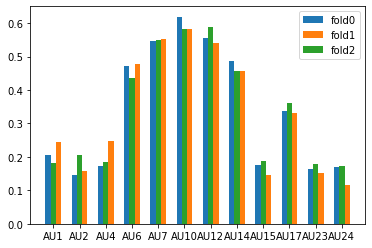

0.004914998646265594


In [26]:
from utils import make_balanced_video_repartition

fold_repartition = make_balanced_video_repartition(activations=bp4d_activation_mat,
                                                   counts=bp4d_counts,
                                                   fold_repartition=12 * [3] + 2 * [2] + [1],
                                                   N=1000)
print(fold_repartition)

fold0_subject = [14, 13, 12, 11, 2]
fold1_subject = [10, 9, 8, 7, 1]
fold2_subject = [6, 5, 4, 3, 2]

aggregated_fold_repartition = np.zeros_like(fold_repartition)

for i in range(fold_repartition.shape[0]):
    assignment = fold_repartition[i]
    if assignment in fold0_subject:
        aggregated_fold_repartition[i] = 0
    if assignment in fold1_subject:
        aggregated_fold_repartition[i] = 1
    if assignment in fold2_subject:
        aggregated_fold_repartition[i] = 2
aggregated_fold_repartition

for i in range(bp4d_subjects.shape[0]):
    bp4d_subject = bp4d_subjects[i]
    assignment_dict[bp4d_subject] = aggregated_fold_repartition[i]
    
bp4d_df['fold'] = bp4d_df['identification'].map(map_dictionary(assignment_dict))

bp4d_df_fold_groupby = bp4d_df[AU_ORDER + ['fold']].groupby('fold')
bp4d_df_fold_ps = bp4d_df_fold_groupby.sum() / bp4d_df_fold_groupby.count()

plt.bar(np.arange(12) - 0.2,
        bp4d_df_fold_ps.iloc[0],
        width=0.2,
        label='fold0',
        tick_label=12 * [''])

plt.bar(np.arange(12) + 0.2,
        bp4d_df_fold_ps.iloc[1],
        width=0.2,
        label='fold1',
        tick_label=12 * [''])

plt.bar(np.arange(12),
        bp4d_df_fold_ps.iloc[2],
        width=0.2,
        label='fold2',
        tick_label=AU_ORDER)
plt.legend()

plt.show()
fold_df_vec = bp4d_df_fold_ps.to_numpy()
variance = np.mean(np.sum(np.power(fold_df_vec - np.mean(fold_df_vec, axis=0)[np.newaxis, :], 2), axis=1))
print(variance)

In [31]:
len(bp4d_subjects)

41

In [32]:
for fold_df in fold_dfs:
    fold_df['sex_id_task_frame'] = fold_df['path'].map(split_sex_id_task_frame)
    fold_df['identification'] = fold_df['sex_id_task_frame'].map(get_tuple(0))
    print(len(fold_df['identification'].unique()))
    

14
14
13


# Result Trombinoscope

In [3]:
from models.interface import get_model
from datasets.bp4d.pandas_interface import columns_bp4d
from metrics_extended.interface import get_metrics
from datasets.bp4d.generation import gen_bp4d
import tensorflow as tf
import os

bp4d_model_dict = dict({
    "main": {
        "type": "encoder_regressor",
        "dependencies": [
            "encoder",
            "regressor"
        ]
    },
    "encoder": {
        "type": "inceptionv3_encoder",
        "optimizer": "encoder",
        "pooling": "max",
        "weights": "imagenet"
    },
    "regressor": {
        "type": "imonet",
        "n_task": 12,
        "n_permutations": 512,
        "drop_out": 128,
        "N_sample": 10,
        "label_units": 64,
        "permutation_units": 64,
        "dependencies": [
            "vector"
        ],
        "permutation_heuristic": {
            "type": "random"
        },
        "recurrent_cell_args": {
            "type": "gruv2",
            "units": 64
        },
        "optimizer": "regressor"
    },
    "vector": {
        "type": "vector",
        "n_permutations": 512,
        "optimizer": "permutation"
    }
})

bp4d_metrics_dict = [
    {
        "type": "auc_roc",
        "num_thresholds": 200,
        "pred_in": "global_pred",
        "n_coords": 12
    }
]
bp4d_columns = columns_bp4d(['AU_binary'])
bp4d_eval_metrics = get_metrics(bp4d_metrics_dict, bp4d_columns, log_folder=None)

bp4d_model = get_model(bp4d_model_dict, frequencies=tf.constant(tf.ones((12, ))))
bp4d_model.build((None, 299, 299, 3))
weight_path = os.path.join('..', 'logs', 'CVPR_submission', 'bp4d_au', 'monet_fwbp', 'iv3', 'fold0', '9041',
                           'checkpoints', '2-epoch')
bp4d_model.load_weights(ckpt_path=weight_path,
                        block="main")

entering dataset metric constructor
{'type': 'encoder_regressor', 'encoder': <models.encoders.inception.Inceptionv3 object at 0x7fbc6c1797f0>, 'frequencies': <tf.Tensor: shape=(12,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>}
{'type': 'imonet', 'n_task': 12, 'n_permutations': 512, 'drop_out': 128, 'N_sample': 10, 'label_units': 64, 'permutation_units': 64, 'permutation_heuristic': {'type': 'random'}, 'recurrent_cell_args': {'type': 'gruv2', 'units': 64}, 'vector': <models.vectors.Vector object at 0x7fbc2856ab80>, 'frequencies': <tf.Tensor: shape=(12,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>}
{'type': 'encoder_regressor', 'encoder': <models.encoders.inception.Inceptionv3 object at 0x7fbc6c1797f0>, 'frequencies': <tf.Tensor: shape=(12,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, 'regressor': <models.regressors.permutation_regressors.

In [5]:
from datasets.bp4d.config import FOLD_TEMPLATE

full_df_path = os.path.join('..', 'resources', 'BP4D', 'preprocessed', 'full_info.csv')
full_df = pd.read_csv(full_df_path)

print(full_df['identification'].unique())


fold_0_id = ['F001', 'M008', 'M004', 'M014', 'M007', 'M001', 'M012', 'F016', 'F002', 'F009', 'F018', 'F008', 'F023', "F010"]
print(len(fold_0_id))

df_identities = []
for identity in fold_0_id:
    full_df_identity = full_df.loc[full_df['identification'] == identity]
    df_identities.append(full_df_identity.sample(500))
    
df = pd.concat(df_identities, axis=0)

    

['M003' 'M015' 'M009' 'M011' 'M002' 'M017' 'M013' 'M008' 'M004' 'M018'
 'M014' 'M005' 'M007' 'M016' 'M010' 'M001' 'M012' 'M006' 'F007' 'F011'
 'F017' 'F016' 'F013' 'F004' 'F005' 'F002' 'F012' 'F019' 'F009' 'F014'
 'F020' 'F018' 'F006' 'F008' 'F023' 'F003' 'F022' 'F015' 'F001' 'F021'
 'F010']
14


In [7]:
predictions = []

for i in tqdm(range(df.shape[0])):
    dest_image = plt.imread(df.iloc[i]['dest_path']) / 255 
    # print(dest_image)
    predictions.append(bp4d_model(np.expand_dims(dest_image, axis=0))['global_pred'])
    
predictions = np.concatenate(predictions, axis=0)
print(predictions.shape)
# threshold = np.tile(fold0_threshold, (70, 1))
# binary_predictions = (predictions - threshold > 0).astype(float)

  0%|          | 0/7000 [00:00<?, ?it/s]

(7000, 12)


In [79]:
pred_df = pd.DataFrame(data=binary_predictions, columns=bp4d_columns)


In [ ]:
from datasets.bp4d.config

In [18]:
predictions = tf.concat(predictions, axis=0)
labels = tf.concat(labels, axis=0)
images = tf.concat(images, axis=0)

In [75]:
AU_order = columns_bp4d(labels=['AU_binary'])
print(AU_order)

def vector_to_detection(v):
    detection = ''
    for i in range(v.shape[0]):
        if v[i] == 1:
            detection += AU_order[i] + ','
    return detection
            
def serie_to_detection(v, index):
    detection = ''
    for i in range(len(index)):
        if v[index[i]] == 1:
            detection += index[i] + ','
    return detection

['AU1', 'AU2', 'AU4', 'AU6', 'AU7', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU23', 'AU24']


In [68]:
final_df

0    1       2   \
0                                                    NaN  NaN     NaN   
1                                                    NaN  NaN     NaN   
2                                                    NaN  NaN     NaN   
3                                                    NaN  NaN     NaN   
4                                                    NaN  NaN     NaN   
5                                                    NaN  NaN     NaN   
6                                                    NaN  NaN     NaN   
7                                                    NaN  NaN     NaN   
8                                                    NaN  NaN     NaN   
9                                                    NaN  NaN     NaN   
10                                                   NaN  NaN     NaN   
11                                                   NaN  NaN     NaN   
12                                                   NaN  NaN     NaN   
13                                                   NaN  NaN     NaN   
14                                                   NaN  NaN     NaN   
15                                                   NaN  NaN     NaN   
16                                                   NaN  NaN     NaN   
17                                                   NaN  NaN     NaN   
18                                                   NaN  NaN     NaN   
19                                                   NaN  NaN     NaN   
20                                                   NaN  NaN     NaN   
21                                                   NaN  NaN     NaN   
22                                                   NaN  NaN     NaN   
23                                                   NaN  NaN     NaN   
24                                                   NaN  NaN     NaN   
25                                                   NaN  NaN     NaN   
26                                                   NaN  NaN     NaN   
27                                                   NaN  NaN     NaN   
28                                                   NaN  NaN     NaN   
29                                                   NaN  NaN     NaN   
30                                                   NaN  NaN     NaN   
31                                                   NaN  NaN     NaN   
32                                                   NaN  NaN     NaN   
33                                                   NaN  NaN     NaN   
34                                                   NaN  NaN     NaN   
35                                                   NaN  NaN     NaN   
36                                                   NaN  NaN     NaN   
37                                                   NaN  NaN     NaN   
38                                                   NaN  NaN     NaN   
39                                                   NaN  NaN     NaN   
40                                                   NaN  NaN     NaN   
41                                                   NaN  NaN     NaN   
42                                                   NaN  NaN     NaN   
43                                                   NaN  NaN     NaN   
44                                                   NaN  NaN     NaN   
45                                                   NaN  NaN     NaN   
46                                                   NaN  NaN     NaN   
47                                                   NaN  NaN     NaN   
48                                                   NaN  NaN     NaN   
49                                                   NaN  NaN     NaN   
50                                                   NaN  NaN     NaN   
51                                                   NaN  NaN     NaN   
52                                                   NaN  NaN     NaN   
53                                                   NaN  NaN     NaN   
54                                     

/tmp/ipykernel_28121/3870218468.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


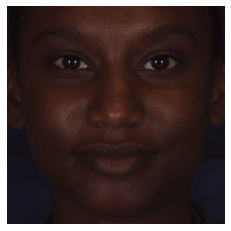

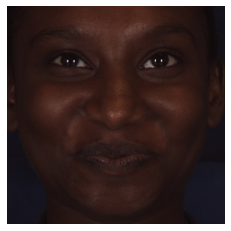

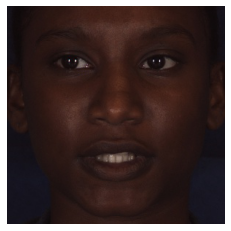

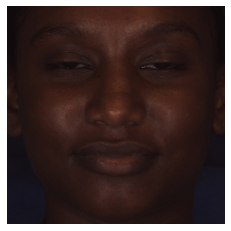

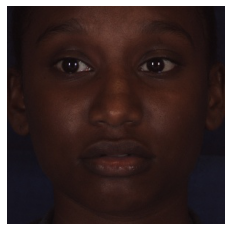

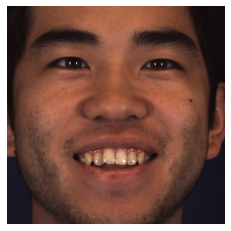

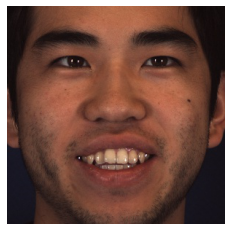

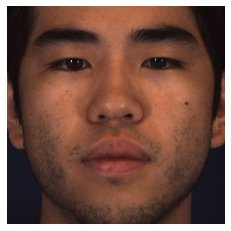

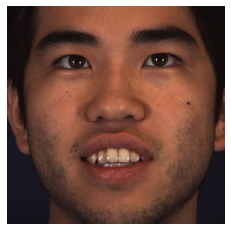

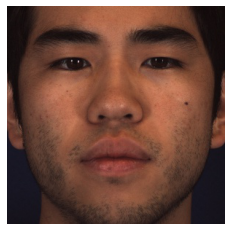

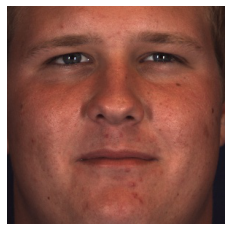

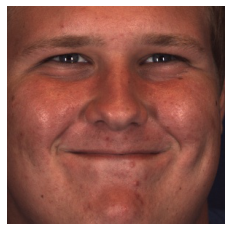

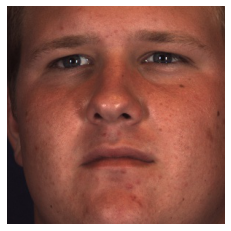

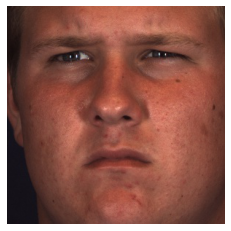

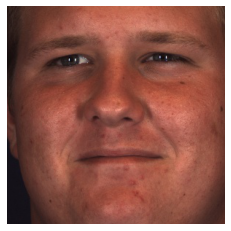

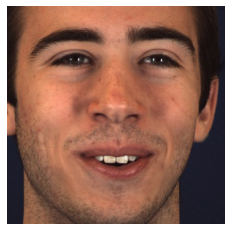

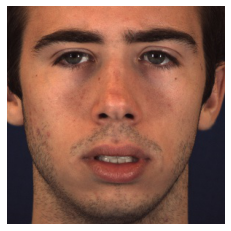

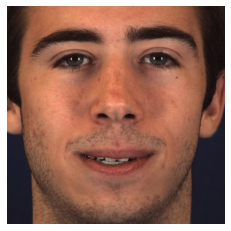

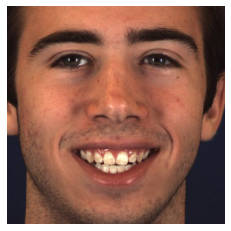

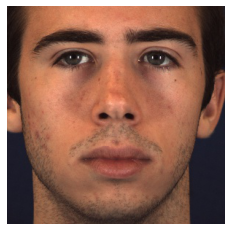

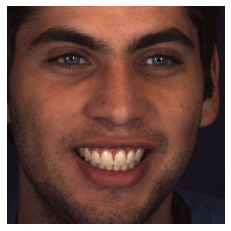

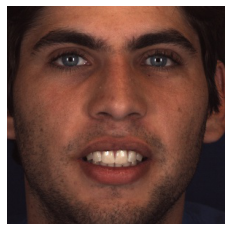

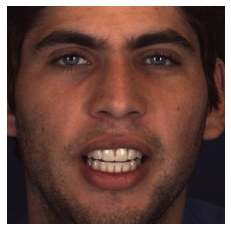

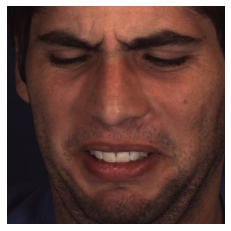

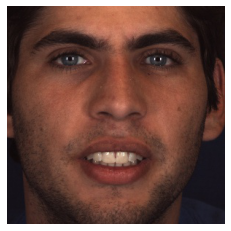

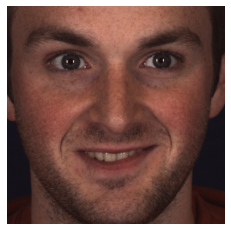

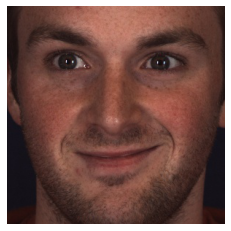

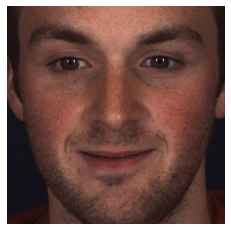

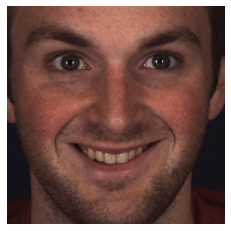

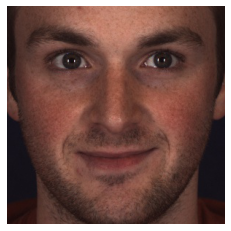

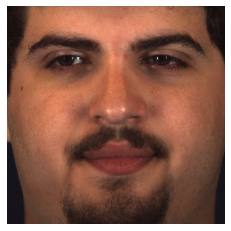

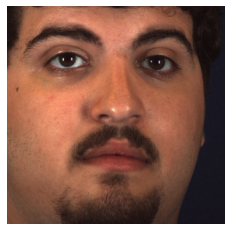

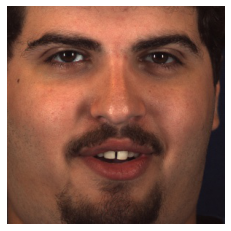

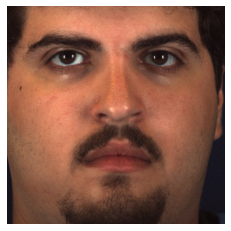

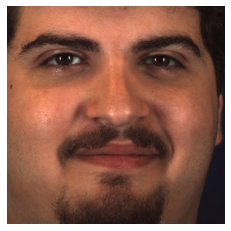

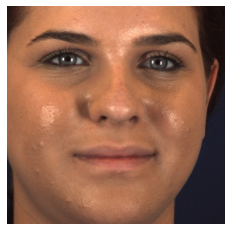

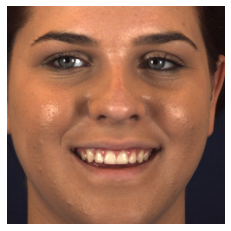

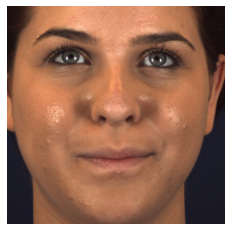

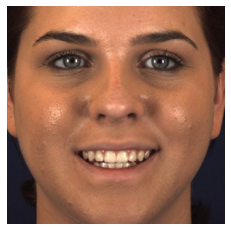

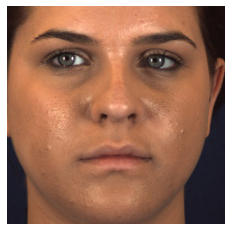

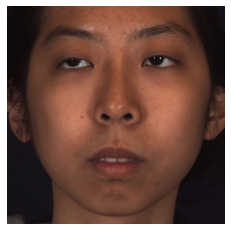

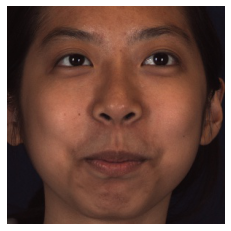

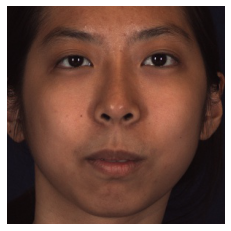

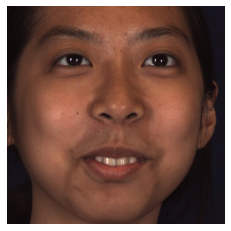

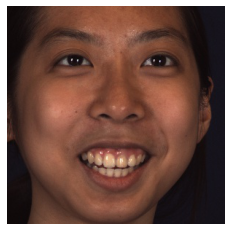

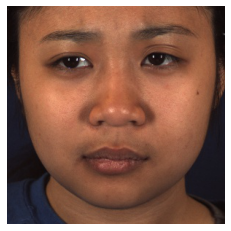

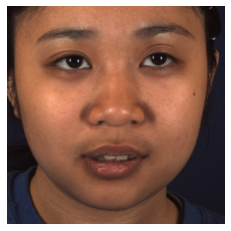

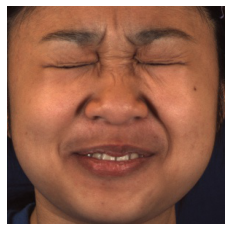

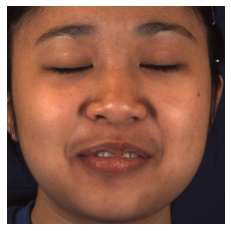

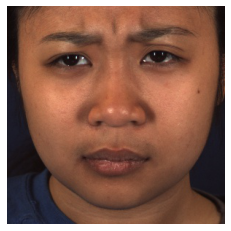

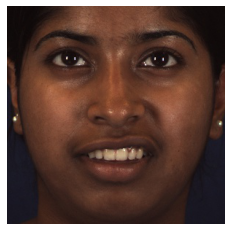

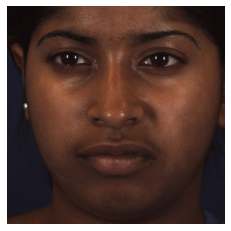

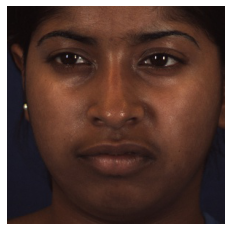

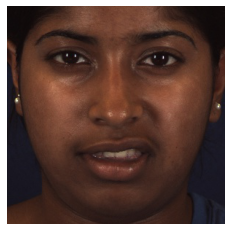

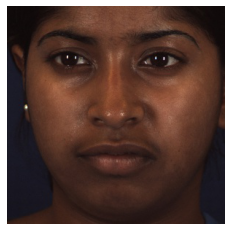

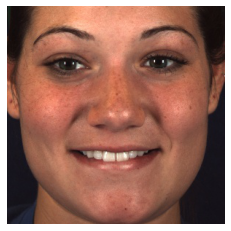

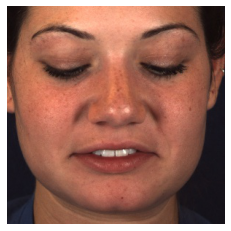

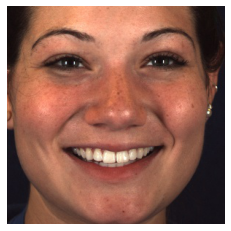

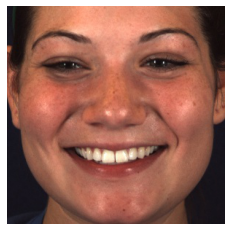

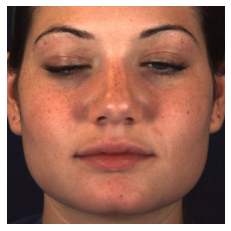

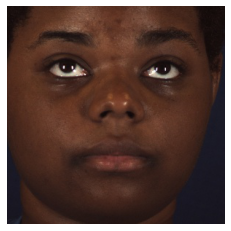

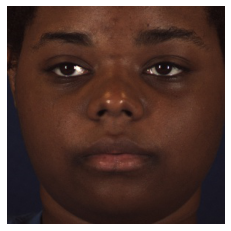

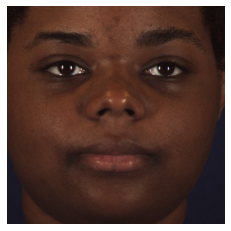

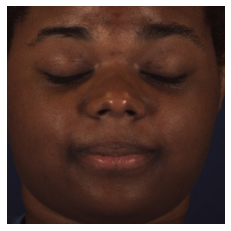

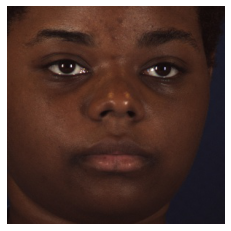

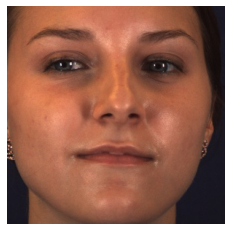

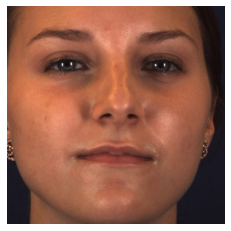

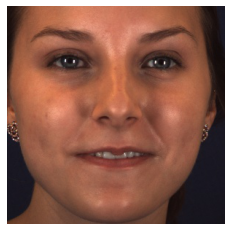

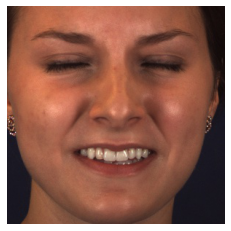

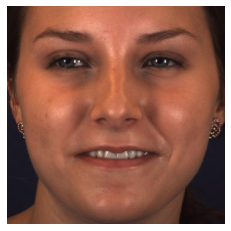

In [84]:
for i in range(70):
    plt.figure()
    gt_str = serie_to_detection(df[bp4d_columns].iloc[i], bp4d_columns)
    pred_str = serie_to_detection(pred_df.iloc[i], pred_df.columns)
    plt.imshow(plt.imread(df.iloc[i]['dest_path']))
    plt.axis('off')
    
    # plt.title('gt={} \n pred={}'.format(gt_str, pred_str))
    plt.savefig(os.path.join('test_images', 'image_{}.png'.format(i)), bbox_inches='tight')

In [29]:
FOLD_PATH_GEN = os.path.join(BP4D_PATH, 'preprocessed', 'folds', 'fold{}.csv')
folds = [0, 1, 2]
fold_dfs = [pd.read_csv(FOLD_PATH_GEN.format(fold)) for fold in folds]
label_projection = ["AU1", "AU2", "AU4", "AU6", "AU7", "AU10", "AU12", "AU14", "AU15", "AU17", "AU23", "AU24"]
activations_list = []
counts_list = []
identifier_list = []
for fold_df in fold_dfs:
    fold_df['identifier'] = (fold_df['path']
                             .map(split_sex_id_task_frame)
                             .map(get_tuple(0)))
    stat_fold_df = fold_df[label_projection + ['identifier']]
    stat_fold_df['label'] = 0
    for i in range(len(label_projection)):
        stat_fold_df['label'] = stat_fold_df['label'] + (2**i) * stat_fold_df[label_projection[i]]
    # print(stat_fold_df[stat_fold_df['label'] == 2 ** len(label_projection) - 1])
    unique_identifiers = stat_fold_df['identifier'].unique()
    
    activations = np.zeros((unique_identifiers.shape[0], 2 ** len(label_projection) - 1))
    counts = np.zeros(unique_identifiers.shape[0], )
    for i in range(unique_identifiers.shape[0]):
        unique_identifier = unique_identifiers[0]
        stat_fold_identifier = stat_fold_df[stat_fold_df['identifier'] == unique_identifier]
        count_values = stat_fold_identifier['label'].value_counts()
        for key in count_values.index:
            activations[i, key] = count_values[key]
        counts[i] = stat_fold_identifier.shape[0]
        
    identifier_list.append(unique_identifiers)
    activations_list.append(activations)
    counts_list.append(counts)
    
    
    
    
    

/tmp/ipykernel_19355/4091494590.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_fold_df['label'] = 0
/tmp/ipykernel_19355/4091494590.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_fold_df['label'] = stat_fold_df['label'] + (2**i) * stat_fold_df[label_projection[i]]


hp    M                                                                            1
      T                                                                           12
      alpha_smooth                                                               0.1
      batchsize                                                                   64
      beta_mixup                                                                 0.4
      ca_order                                                                    yx
      d_model                                                                    128
      d_model_x                                                                  256
      d_model_y                                                                  128
      epochs                                                                      50
      epsilon_decoder                                                            0.0
      epsilon_encoder                                            

<AxesSubplot:xlabel='epoch', ylabel='train_mean_AUC_ROC'>

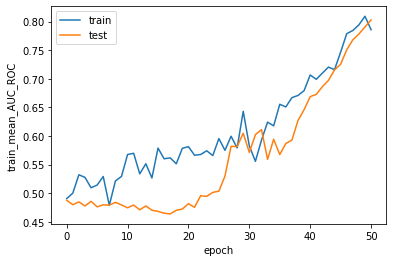

In [125]:
import os
import pandas as pd
from utils import dict_from_json
from experiment_parser_extended import MetaExperimentParser
import seaborn as sns
# import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from datasets.bp4d.config import AU_ORDER

pd.set_option('display.max_rows', None)


from datasets.bp4d.config import AU_ORDER
from pandas_utils import select_with_hp_dict

file = os.path.join("..", "experiments", "ECCV_submission", "bp4d", "ivit_motcat", "fwbce_pretrain", "sanity.json") 
dictionary = dict_from_json(file)
experiment = MetaExperimentParser(dictionary)

storing_path = experiment.get_storing_path()
df = pd.read_csv(storing_path, header=[0, 1])

n = 20

# warmup30_df = pd.read_csv(df['meta', 'tracking'].loc[df['hp', 'lr0_warmup_encoder'] == 30].iloc[0])
hp_dict = dict({"batchsize": 64,
                "num_layers_y": 2,
                "num_layers_x": 1,
                "lr0_warmup_decoder": 2,
                "lr0_scale_decoder": 1.0,
                "lr0_encoder": 5e-5,
                "d_model_x": 256,
                "epochs": 100})

# df_experiment = select_with_hp_dict(hp_dict, df).iloc[-1]
df_experiment = df.iloc[-1]
print(df_experiment)
tracking_df = pd.read_csv(df_experiment['meta', 'tracking'])


# sns.lineplot(data=tracking_df, x='epoch', y='train_mean_AUC_ROC', label='test')
sns.lineplot(data=tracking_df, x='epoch', y='train_mean_AUC_ROC', label='train')
sns.lineplot(data=tracking_df, x='epoch', y='test_mean_AUC_ROC', label='test')


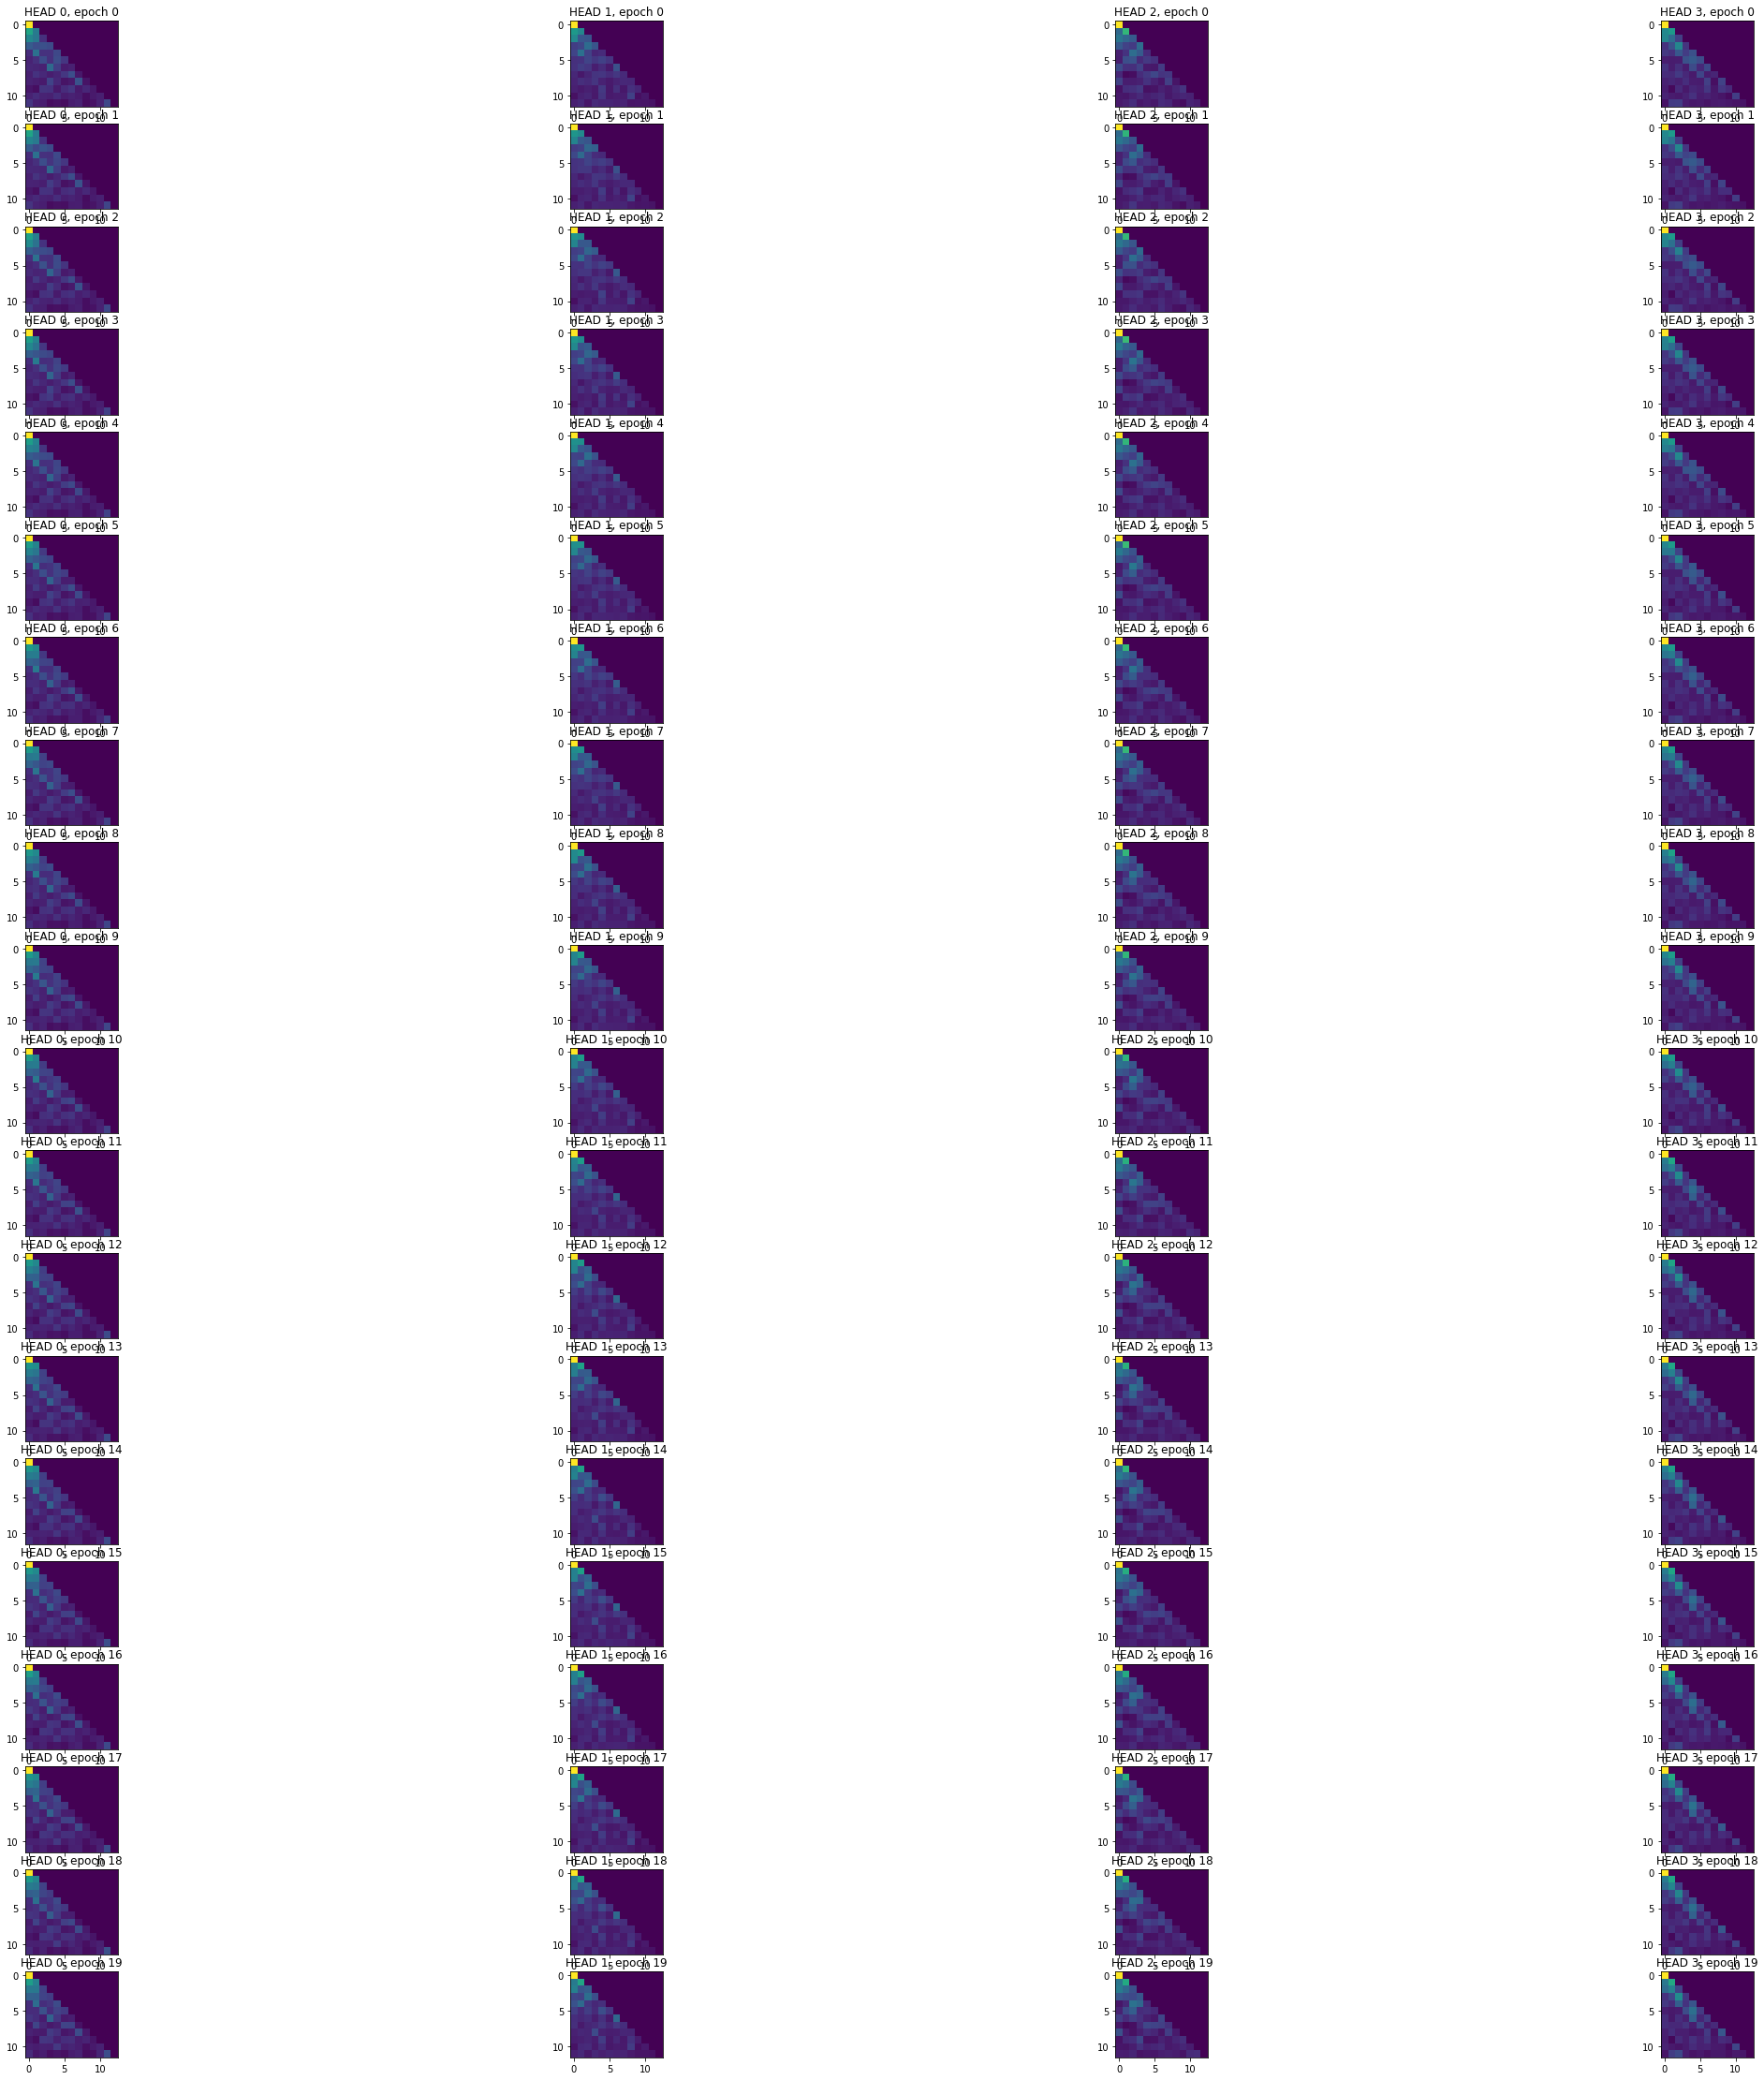

In [126]:
n_h = 4
epochs = [i for i in range(20)]
fig, axes = plt.subplots(nrows=len(epochs), ncols=n_h, figsize=(40, 40))
for i in range(len(epochs)):
    epoch = epochs[i]
    ty_att = np.load(tracking_df.loc[tracking_df['epoch'] == epoch]['train_layer_0_block_ty'].iloc[0])
    for j in range(n_h):
        axes[i][j].imshow(ty_att[j], vmin=0)
        axes[i][j].set_title('HEAD {}, epoch {}'.format(j, epoch))

In [95]:
from pandas_utils import opt_hp_on_test
import functools
import math

def get_eval_from_hp_on_test(test_metric, test_df, eval_metric, eval_df, opt):
    best_hp, best_result = opt_hp_on_test(test_metric, test_df, opt)
    best_hp = best_hp.iloc[0]
    best_epoch, best_hp = best_hp['epoch'], best_hp.drop(['epoch', 'epochs']).to_dict()
    print(eval_df['hp', 'pooling'].isna())
    best_eval_df = select_with_hp_dict(best_hp, eval_df).iloc[0]
    tracking_eval = pd.read_csv(best_eval_df['meta', 'tracking'])
    return tracking_eval[tracking_eval['epoch'] == best_epoch][eval_metric]

def select_with_hp_dict(hp_dict, df):
    conditions = [(df['hp', key] == hp_dict[key]) | (df['hp', key].isna() & pd.isna(hp_dict[key])) for key in hp_dict]
    cond = functools.reduce(lambda x, y: x & y, conditions)
    return df.loc[cond]


result = get_eval_from_hp_on_test(test_metric='eval_mean_AUC_ROC',
                                  test_df=df,
                                  eval_metric='eval_mean_AUC_ROC',
                                  eval_df=df,
                                  opt='max')
best_hp, best_result = opt_hp_on_test('eval_mean_AUC_ROC', df, 'max')
print(best_result)
hp['lr0_encoder']
result

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
Name: (hp, pooling), dtype: bool
   epoch_and_test  eval_mean_AUC_ROC
5  (4, 0.8230756)           0.823076


4    0.823076
Name: eval_mean_AUC_ROC, dtype: float64

In [85]:
pd.isna('coucou')

False

In [78]:
True == True

True

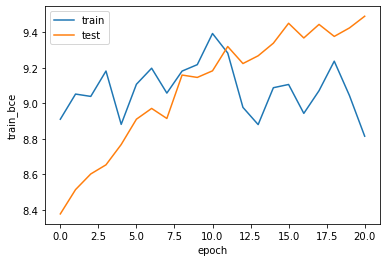

<AxesSubplot:xlabel='epoch', ylabel='train_bce'>

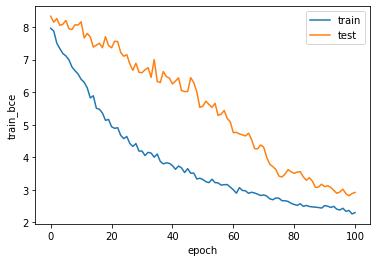

In [3]:
import os
import pandas as pd
from utils import dict_from_json
from experiment_parser_extended import MetaExperimentParser
import seaborn as sns
# import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from datasets.abaw3.config import AU_ORDER

pd.set_option('display.max_rows', None)


from datasets.bp4d.config import AU_ORDER
from pandas_utils import select_with_hp_dict

file = os.path.join("..", "experiments", "ECCV_submission", "bp4d", "mrnn", "cross_val", "sanity.json") 
dictionary = dict_from_json(file)
experiment = MetaExperimentParser(dictionary)

storing_path = experiment.get_storing_path()
df = pd.read_csv(storing_path, header=[0, 1])

n = 20

# warmup30_df = pd.read_csv(df['meta', 'tracking'].loc[df['hp', 'lr0_warmup_encoder'] == 30].iloc[0])
hp_dict = dict({"epochs": 100,
                "ignore_mixup": True})

df_experiment = df.iloc[-1]

tracking_df = pd.read_csv(df_experiment['meta', 'tracking'])
sns.lineplot(data=tracking_df, x='epoch', y='train_bce', label='train')
sns.lineplot(data=tracking_df, x='epoch', y='test_bce', label='test')

In [75]:
from pandas_utils import opt_hp_on_test_for_eval
hp, result = opt_hp_on_test_for_eval(test_metric='test_static_mean_f1score',
                        eval_metric='eval_static_mean_f1score',
                        df=df,
                        opt='max')
hp

M   T  alpha_smooth  batchsize  beta_mixup ca_order  d_model  d_model_x  \
0  1  12           0.1         64         0.4       yx       64        256   

   d_model_y  epochs  ...  wd0_lin_phase_decoder  wd0_lin_phase_encoder  \
0         64      20  ...                      5                      5   

   wd0_lin_phase_transformer  wd0_transformer  wd0_warmup_decoder  \
0                          5              0.0                   5   

   wd0_warmup_encoder  wd0_warmup_transformer  weight_fwdice  zoom_factor  \
0                   5                       5            0.5          0.1   

   epoch  
0      7  

[1 rows x 73 columns]

In [76]:
result

epoch_test_eval  test_static_mean_f1score  \
0  (7, 0.6864202, 0.5954824)                   0.68642   

   eval_static_mean_f1score  
0                  0.595482

(8, 12, 64)
(8, 12, 64)
(8, 12, 64)
(8, 12, 64)
(8, 12, 64)


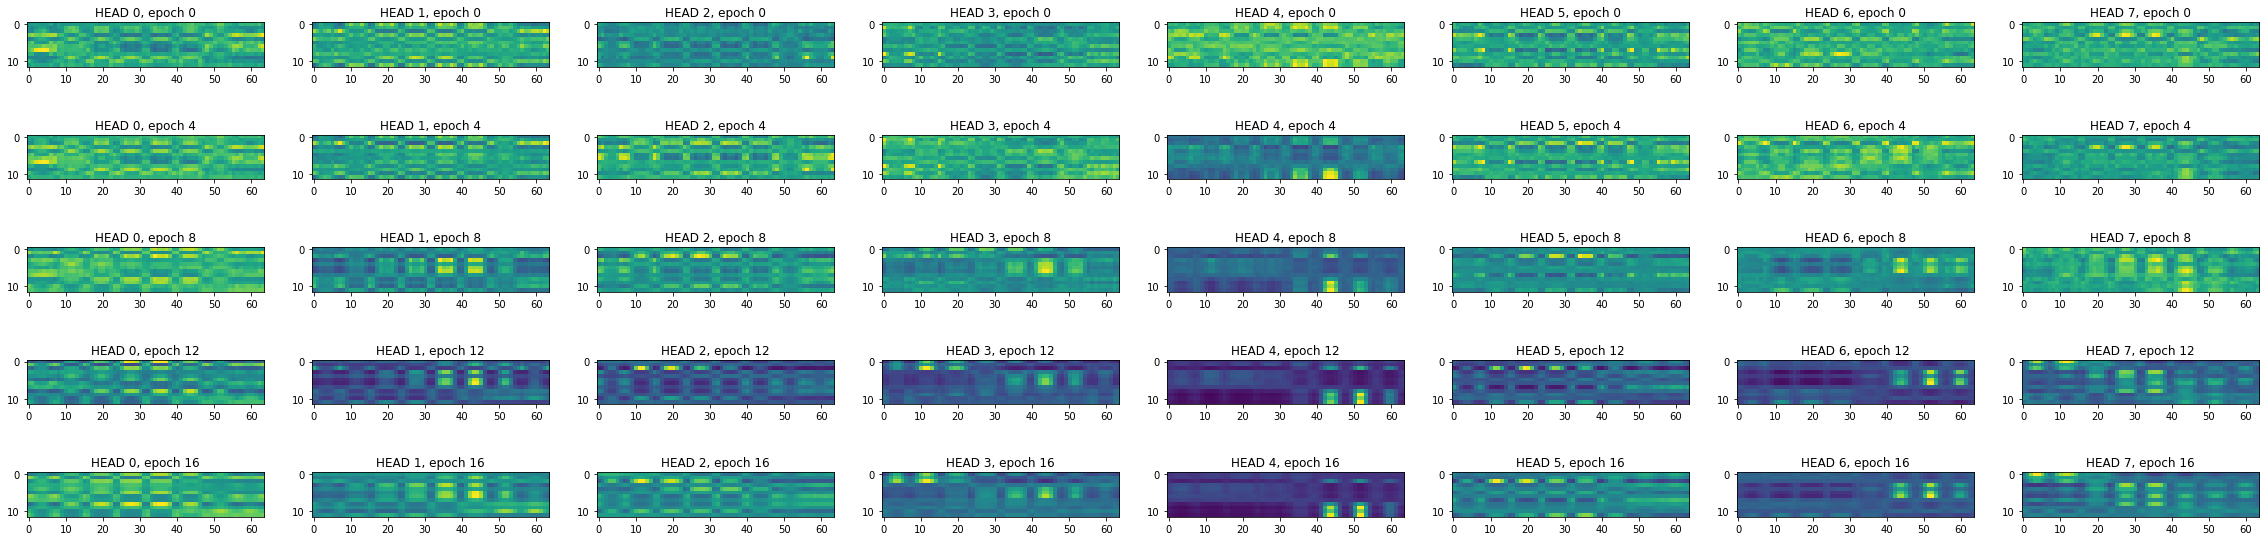

In [77]:
n_h = 8
from scipy.stats import entropy
epochs = [4 * i for i in range(5)]
fig, axes = plt.subplots(nrows=len(epochs), ncols=n_h, figsize=(40, 10))
for i in range(len(epochs)):
    epoch = epochs[i]
    ty_att = np.load(tracking_df.loc[tracking_df['epoch'] == epoch]['train_layer_0_block_tx'].iloc[0])
    print(ty_att.shape)
    for j in range(n_h):
        axes[i][j].imshow(ty_att[j], vmin=0)
        axes[i][j].set_title('HEAD {}, epoch {}'.format(j, epoch))

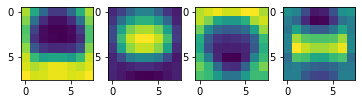

In [90]:
num_heads = 4
au = 11
fig, axes = plt.subplots(nrows=1, ncols=num_heads)
for i in range(num_heads):
    axes[i].imshow(ty_att[i][au].reshape(8, 8))

In [34]:
folds = [0, 1, 2]
full_bp4d = pd.concat([pd.read_csv(FOLD_PATH_GEN.format(fold)) for fold in folds], axis=0)
full_bp4d.shape[0] / 64

2289.765625

# ABAW3 DATA PREPARATION

In [33]:
labels_path = 

def get_landmarks(x):
    features_2D = np.load(x['2D_features'])
    has_landmarks = ('landmarks' in features_2D)
    if 'landmarks' in features_2D:
        landmarks = features_2D['landmarks']
    else:
        landmarks = None
    return landmarks
def has_landmarks(landmarks):
    return not(landmarks is None)

def get_unique_id(task, )
def get_labels_path(identification, )

In [34]:
from tqdm.notebook import tqdm
tqdm.pandas()

bp4d_dataset = pd.read_csv(PREPROCESSED_DF)
bp4d_dataset['landmarks'] = bp4d_dataset.progress_apply(get_landmarks, axis=1)

  0%|          | 0/146847 [00:00<?, ?it/s]

In [22]:
bp4d_dataset['has_landmarks'] = bp4d_dataset['landmarks'].progress_map(has_landmarks)
bp4d_dataset_filtered = bp4d_dataset[bp4d_dataset['has_landmarks']]
bp4d_dataset

  0%|          | 0/146847 [00:00<?, ?it/s]

src_path  task  frame  \
0       ../resources/BP4D/raw/sequences/M003/T7/1793.jpg     7   1793   
1       ../resources/BP4D/raw/sequences/M003/T7/1397.jpg     7   1397   
2       ../resources/BP4D/raw/sequences/M003/T7/1524.jpg     7   1524   
3       ../resources/BP4D/raw/sequences/M003/T7/1700.jpg     7   1700   
4       ../resources/BP4D/raw/sequences/M003/T7/1877.jpg     7   1877   
...                                                  ...   ...    ...   
146842   ../resources/BP4D/raw/sequences/F010/T8/028.jpg     8     28   
146843   ../resources/BP4D/raw/sequences/F010/T8/082.jpg     8     82   
146844   ../resources/BP4D/raw/sequences/F010/T8/170.jpg     8    170   
146845   ../resources/BP4D/raw/sequences/F010/T8/102.jpg     8    102   
146846   ../resources/BP4D/raw/sequences/F010/T8/180.jpg     8    180   

                                                dest_path  \
0       ../resources/BP4D/preprocessed/sequences/M003/...   
1       ../resources/BP4D/preprocessed/sequences/M003/...   
2       ../resources/BP4D/preprocessed/sequences/M003/...   
3       ../resources/BP4D/preprocessed/sequences/M003/...   
4       ../resources/BP4D/preprocessed/sequences/M003/...   
...                                                   ...   
146842  ../resources/BP4D/preprocessed/sequences/F010/...   
146843  ../resources/BP4D/preprocessed/sequences/F010/...   
146844  ../resources/BP4D/preprocessed/sequences/F010/...   
146845  ../resources/BP4D/preprocessed/sequences/F010/...   
146846  ../resources/BP4D/preprocessed/sequences/F010/...   

                                              2D_features  AU1  AU2  AU4  AU6  \
0       ../resources/BP4D/preprocessed/2DFeatures/M003...    0    0    0    1   
1       ../resources/BP4D/preprocessed/2DFeatures/M003...    0    0    0    0   
2       ../resources/BP4D/preprocessed/2DFeatures/M003...    1    0    0    0   
3       ../resources/BP4D/preprocessed/2DFeatures/M003...    0    0    0    1   
4       ../resources/BP4D/preprocessed/2DFeatures/M003...    0    0    0    0   
...                                                   ...  ...  ...  ...  ...   
146842  ../resources/BP4D/preprocessed/2DFeatures/F010...    0    0    0    0   
146843  ../resources/BP4D/preprocessed/2DFeatures/F010...    0    0    1    1   
146844  ../resources/BP4D/preprocessed/2DFeatures/F010...    0    0    0    1   
146845  ../resources/BP4D/preprocessed/2DFeatures/F010...    0    0    1    1   
146846  ../resources/BP4D/preprocessed/2DFeatures/F010...    0    0    0    1   

        AU7  AU10  AU12  AU14  AU15  AU17  AU23  AU24 identification  \
0         1     1     1     1     1     0     0     0           M003   
1         0     1     1     0     0     0     1     0           M003   
2         0     0     0     1     0     1     1     0           M003   
3         1     1     1     1     1     1     0     0           M003   
4         1     1     1     1     1     0     0     0           M003   
...     ...   ...   ...   ...   ...   ...   ...   ...            ...   
146842    1     0     1     0     0     1     0     0           F010   
146843    1     1     1     0     1     1     0     0           F010   
146844    1     1     1     0     1     1     1     0           F010   
146845    1     1     1     0     1     1     0     0           F010   
146846    0     1     1     0     1     1     0     0           F010   

       landmarks  has_landmarks  
0           None          False  
1           None          False  
2           None          False  
3           None          False  
4           None          False  
...          ...            ...  
146842      None          False  
146843      None          False  
146844      None          False  
146845      None          False  
146846      None          False  

[146847 rows x 20 columns]

In [28]:
np.load(bp4d_dataset['2D_features'].iloc[0])['landmarks']

array([[503.87842, 536.58575, 571.9027 , 608.66284, 641.9917 , 771.6654 ,
        810.93475, 850.2306 , 885.2253 , 912.3213 , 700.5415 , 694.6822 ,
        689.67834, 685.81287, 618.30817, 643.9381 , 671.2786 , 697.28876,
        722.5724 , 518.62585, 549.33606, 581.1464 , 604.11383, 574.8456 ,
        544.0032 , 767.6661 , 802.9587 , 836.84894, 858.51984, 827.6177 ,
        796.1831 , 524.4779 , 562.8638 , 611.3978 , 659.591  , 707.04913,
        747.1491 , 762.54224, 727.2969 , 676.129  , 621.85144, 574.0304 ,
        537.65894, 588.69525, 649.40173, 707.20447, 698.0636 , 633.7041 ,
        575.0046 ],
       [504.2796 , 491.143  , 493.2347 , 501.288  , 520.41437, 546.11456,
        542.5818 , 554.6203 , 572.77014, 600.4997 , 598.7292 , 641.7386 ,
        681.24725, 723.53894, 754.1398 , 765.3472 , 777.63904, 778.5314 ,
        780.09143, 579.6235 , 569.3451 , 579.1528 , 606.4501 , 605.83795,
        597.45966, 642.509  , 629.131  , 637.7103 , 660.2666 , 666.46533,
        658.72797,